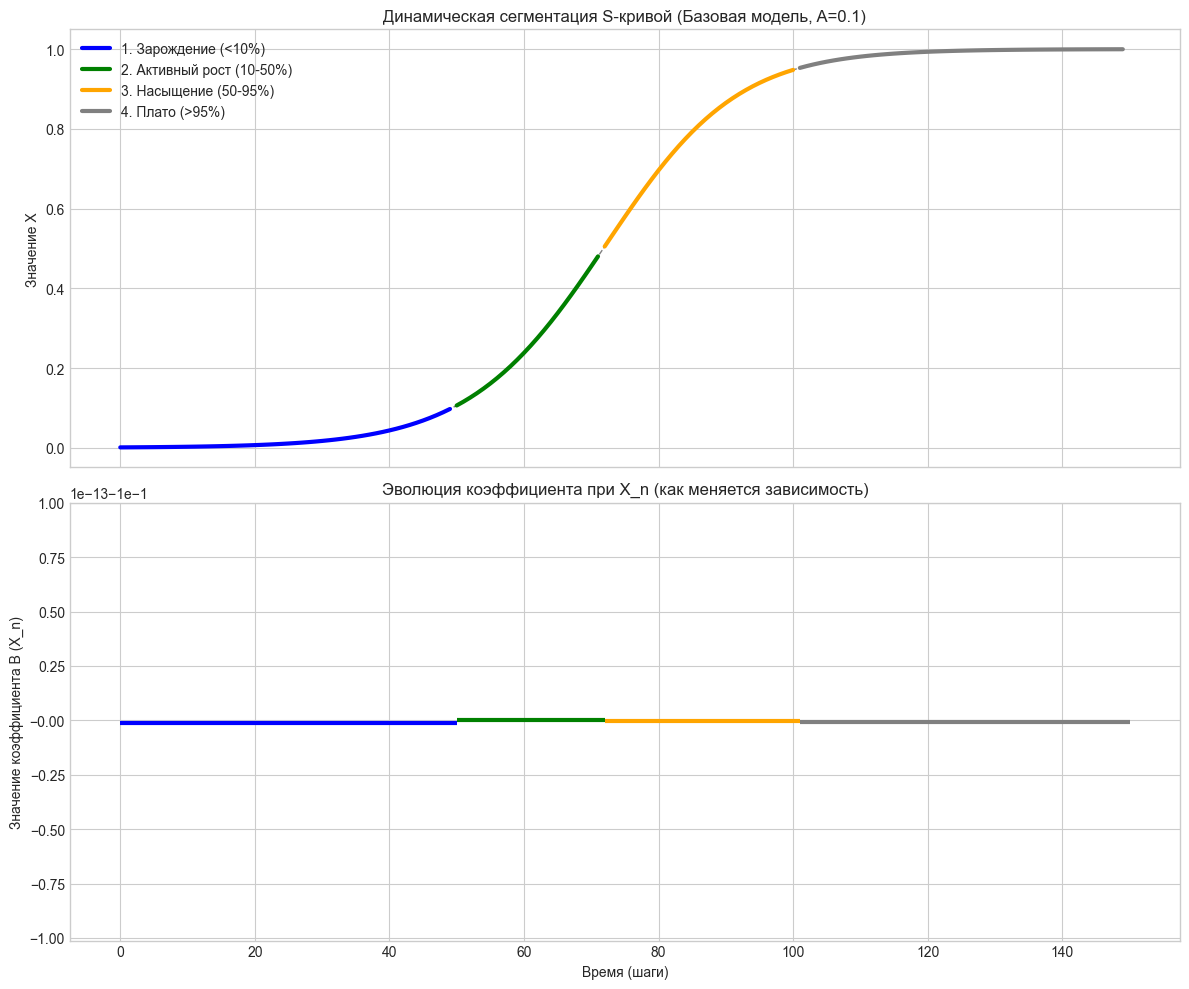

                     Этап Интервал Переменные           Коэффициенты  R2
     1. Зарождение (<10%)     0-50    ['X_n'] Const=0.10, X_n=-0.100 1.0
2. Активный рост (10-50%)    50-72    ['X_n'] Const=0.10, X_n=-0.100 1.0
    3. Насыщение (50-95%)   72-101    ['X_n'] Const=0.10, X_n=-0.100 1.0
          4. Плато (>95%)  101-150    ['X_n'] Const=0.10, X_n=-0.100 1.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

# 1. ГЕНЕРАЦИЯ (Чистая базовая модель, без искусственных шоков)
def generate_process_basic(A, K=1.0, x0=0.001, steps=100):
    x = np.zeros(steps)
    x[0] = x0
    for i in range(steps - 1):
        x[i+1] = x[i] + x[i] * A * (K - x[i])
        # Защита от переполнения
        if x[i+1] > K * 1.5: x[i+1] = K * 1.5
    return x

# 2. АЛГОРИТМ ДИНАМИЧЕСКОЙ СЕГМЕНТАЦИИ
def find_lifecycle_stages(x_series, K=1.0):
    """
    Автоматически определяет индексы начала и конца стадий
    на основе уровня заполнения ниши (X / K).
    """
    stages = {}
    n = len(x_series)
    
    # Индексы, где условие выполняется
    idx_startup = np.where(x_series < 0.1 * K)[0]
    idx_growth  = np.where((x_series >= 0.1 * K) & (x_series < 0.5 * K))[0]
    idx_mature  = np.where((x_series >= 0.5 * K) & (x_series < 0.95 * K))[0]
    idx_plateau = np.where(x_series >= 0.95 * K)[0]
    
    # Функция-помощник для поиска непрерывных кусков
    def get_bounds(indices):
        if len(indices) < 3: return None # Слишком мало точек
        return (indices[0], indices[-1] + 1) # +1 для слайсинга python

    if len(idx_startup) > 0: stages['1. Зарождение (<10%)'] = get_bounds(idx_startup)
    if len(idx_growth) > 0:  stages['2. Активный рост (10-50%)'] = get_bounds(idx_growth)
    if len(idx_mature) > 0:  stages['3. Насыщение (50-95%)'] = get_bounds(idx_mature)
    if len(idx_plateau) > 0: stages['4. Плато (>95%)'] = get_bounds(idx_plateau)
    
    return stages

# 3. STEPWISE (Твоя функция)
def stepwise_selection(X, y, initial_list=[], threshold_in=0.01, threshold_out=0.05):
    included = list(initial_list)
    while True:
        changed = False
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            try:
                model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
                new_pval[new_column] = model.pvalues[new_column]
            except: continue
        if not new_pval.empty:
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                included.append(best_feature)
                changed = True
        if len(included) > 0:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
            pvalues = model.pvalues.iloc[1:]
            if not pvalues.empty:
                worst_pval = pvalues.max()
                if worst_pval > threshold_out:
                    worst_feature = pvalues.idxmax()
                    included.remove(worst_feature)
                    changed = True
        if not changed:
            break
    return included

# --- ЗАПУСК ---

# Уменьшаем A, чтобы процесс шел медленнее и мы поймали все стадии
K_sim = 1.0
A_sim = 0.1  
steps_sim = 150 # Чуть больше шагов, так как процесс медленнее

X_data = generate_process_basic(A_sim, K_sim, steps=steps_sim)
stages = find_lifecycle_stages(X_data, K_sim)

# Визуализация
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# График динамики с раскраской зон
ax1.plot(X_data, color='black', linewidth=1, linestyle='--', alpha=0.5)
ax1.set_title(f"Динамическая сегментация S-кривой (Базовая модель, A={A_sim})")
ax1.set_ylabel("Значение X")

colors = {'1': 'blue', '2': 'green', '3': 'orange', '4': 'gray'}
results_log = []

for name, bounds in stages.items():
    if bounds is None: continue
    start, end = bounds
    
    # Отрисовка на графике
    segment_X = X_data[start:end]
    stage_key = name[0] # '1', '2'...
    ax1.plot(range(start, end), segment_X, color=colors.get(stage_key, 'red'), linewidth=3, label=name)
    
    # --- РЕГРЕССИЯ ДЛЯ СЕГМЕНТА ---
    # 1. Считаем omega (темп прироста)
    x_curr = segment_X[:-1]
    x_next = segment_X[1:]
    
    # Защита от деления на 0 на старте
    safe_x = x_curr.copy()
    safe_x[safe_x == 0] = 1e-9
    
    omega = (x_next - x_curr) / safe_x
    
    # 2. Предикторы
    df = pd.DataFrame({'omega': omega, 'X_n': x_curr})
    df['Lag_1'] = pd.Series(x_curr).shift(1) # Добавим Lag_1, чтобы проверить, не найдет ли он его ложно
    df = df.dropna()
    
    if len(df) > 3:
        Y = df['omega']
        X_mat = df[['X_n', 'Lag_1']]
        
        # Запускаем Stepwise
        selected = stepwise_selection(X_mat, Y)
        
        # Получаем коэффициенты
        coef_str = "Нет"
        r2 = 0
        if len(selected) > 0:
            mod = sm.OLS(Y, sm.add_constant(X_mat[selected])).fit()
            r2 = mod.rsquared
            
            # Формируем строку коэффициентов
            c_list = []
            if 'const' in mod.params: c_list.append(f"Const={mod.params['const']:.2f}")
            for var in selected:
                c_list.append(f"{var}={mod.params[var]:.3f}")
            coef_str = ", ".join(c_list)
            
        results_log.append({
            "Этап": name,
            "Интервал": f"{start}-{end}",
            "Переменные": str(selected),
            "Коэффициенты": coef_str,
            "R2": r2
        })
        
        # Для графика коэффициентов (визуализация эволюции)
        # Если X_n выбран, рисуем его коэффициент
        if 'X_n' in selected:
            # Рисуем линию коэффициента на всем интервале этапа
            ax2.hlines(mod.params['X_n'], start, end, colors=colors.get(stage_key, 'red'), linewidth=3)
        else:
            ax2.hlines(0, start, end, colors=colors.get(stage_key, 'red'), linewidth=3, linestyle=':')

ax1.legend()
ax2.set_title("Эволюция коэффициента при X_n (как меняется зависимость)")
ax2.set_ylabel("Значение коэффициента B (X_n)")
ax2.set_xlabel("Время (шаги)")
ax2.grid(True)

plt.tight_layout()
plt.show()

# Вывод таблицы текстом
res_df = pd.DataFrame(results_log)
print(res_df.to_string(index=False))

# ОТЧЕТ ПО ЭТАПУ: ДИНАМИЧЕСКАЯ СЕГМЕНТАЦИЯ И ЛОКАЛЬНЫЙ АНАЛИЗ S-ОБРАЗНОЙ КРИВОЙ

### 1. Постановка задачи и методология
В соответствии с рекомендацией научного руководителя была проведена детализация исследования базовой модели. Цель этапа — проверить устойчивость работы регрессионного анализа на **коротких выборках данных**, соответствующих различным стадиям жизненного цикла компании (системы). Это приближает условия эксперимента к реальному экономическому анализу, где исследователю редко доступны длинные временные ряды, охватывающие весь период существования компании.

**Методика эксперимента:**
1.  **Генерация:** Использована базовая логистическая модель с параметром малой интенсивности ($A=0.1$), что позволило растянуть процесс во времени и получить детальную S-образную кривую роста.
2.  **Динамическая сегментация:** Разработан алгоритм, автоматически разделяющий временной ряд на 4 фундаментальные стадии развития на основе уровня освоения потенциала ($X/K$):
    *   *Зарождение* (до 10% рынка);
    *   *Активный рост* (10–50%);
    *   *Насыщение* (50–95%);
    *   *Плато / Зрелость* (свыше 95%).
3.  **Локальная регрессия:** Для каждого сегмента независимо строилась модель авторегрессии методом пошагового отбора (Stepwise) для оценки зависимости темпов прироста $\omega$ от текущего состояния $X_n$.

### 2. Результаты локального анализа

Результаты моделирования для всех четырех стадий представлены в таблице:

| Этап Жизненного Цикла | Интервал (шаги) | Отобранные переменные | Коэффициент Constant | Коэффициент при $X_n$ | $R^2$ |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **1. Зарождение** | 0–50 | `['X_n']` | $0.10$ | $-0.100$ | $1.0$ |
| **2. Активный рост** | 50–72 | `['X_n']` | $0.10$ | $-0.100$ | $1.0$ |
| **3. Насыщение** | 72–101 | `['X_n']` | $0.10$ | $-0.100$ | $1.0$ |
| **4. Плато** | 101–150 | `['X_n']` | $0.10$ | $-0.100$ | $1.0$ |

**Визуализация:** График эволюции коэффициента $B(X_n)$ представляет собой прямую линию на уровне $-0.1$ без флуктуаций.

### 3. Интерпретация и сопряжение с предыдущими результатами

Полученные результаты позволяют сделать ряд важных выводов, которые связывают этот локальный эксперимент с глобальным анализом режимов (Хаос/Стабильность), проведенным ранее.

#### А. Подтверждение инвариантности закона развития
Анализ показал, что для детерминированной базовой модели закон эволюции (связь между темпом прироста и размером системы) является **инвариантным** на всем протяжении жизненного цикла.
*   Уравнение темпа прироста $\omega_n = A - A \cdot X_n$ выполняется строго на каждом участке.
*   Регрессионный анализ успешно идентифицирует параметры $A$ (Const) и $-A$ (коэффициент при $X_n$) как на этапе бурного роста, так и на этапе затухания.
*   **Связь с предыдущим:** Ранее мы показали, что в режиме *стабильности* ($AK < 2$) модель работает на длинных рядах. Теперь мы доказали, что она работает и на **коротких отрезках** (15-30 точек), что критически важно для анализа реальных компаний, статистика по которым ограничена.

#### Б. Отсутствие структурных сдвигов в базовой модели
Тот факт, что коэффициенты не меняются при переходе от «Роста» к «Плато», означает, что в рамках базовой модели **механизм торможения** заложен изначально и действует постоянно. Система не меняет «режим работы», она просто реагирует на изменение переменной $X$.
*   Это важный **диагностический маркер**: если при анализе реальной компании мы увидим резкое изменение коэффициентов регрессии (например, на этапе роста коэффициент был $-0.1$, а на плато стал $-0.5$), это будет свидетельствовать о **структурном сдвиге** (изменении внешней среды или стратегии), который базовая модель Ферхюльста не описывает.

#### В. Различие с режимами Хаоса и Запаздывания
Данный результат служит идеальным «базовым уровнем» (Baseline) для сравнения с более сложными ситуациями, выявленными в дипломе:
1.  **В сравнении с Хаосом ($AK=2.8$):** В режиме хаоса (предыдущие главы) мы видели, что Stepwise начинал находить ложные лаги ($Lag\_5$ и т.д.) из-за турбулентности. В режиме S-кривой Stepwise работает чисто, выбирая только физически обоснованный $X_n$.
2.  **В сравнении с Запаздыванием (будущие главы):** Мы ожидаем, что в моделях с памятью (особенно с $\gamma < 0$, инвестиции) коэффициенты на разных этапах **будут отличаться**. Например, на этапе старта влияние прошлого может быть минимальным, а на этапе роста — ключевым. Текущий результат (стабильность коэффициентов) доказывает, что если мы видим динамику параметров в будущем — это не ошибка метода, а свойство более сложной модели.

### 4. Итоговый вывод в контексте исследования

> «Проведенная детализация подтвердила, что линейный регрессионный анализ методом скользящего окна (по стадиям жизненного цикла) является **робастным инструментом идентификации** для процессов логистического типа. Метод корректно восстанавливает параметры генерации данных даже на коротких выборках.
>
> Стабильность полученных коэффициентов служит доказательством того, что наблюдаемая динамика (S-образный рост) порождена единым неизменным законом без структурных разрывов. Это создает методическую базу для следующего этапа — анализа **смешанных моделей**, где ожидается дрейф коэффициентов, отражающий изменение роли "памяти" системы по мере её развития».